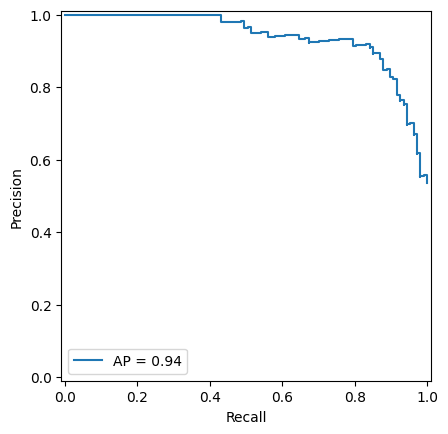

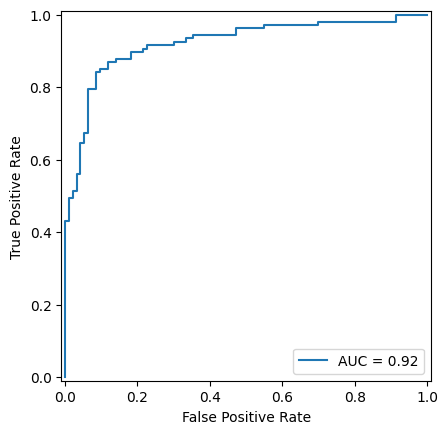

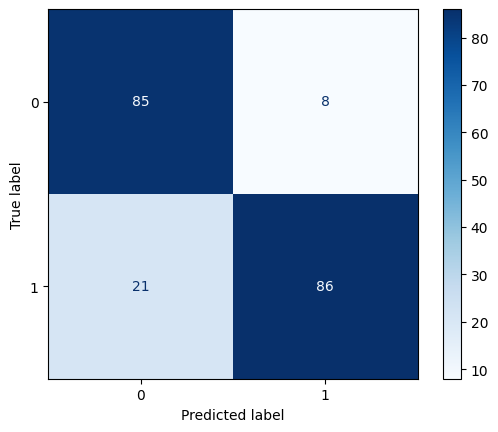

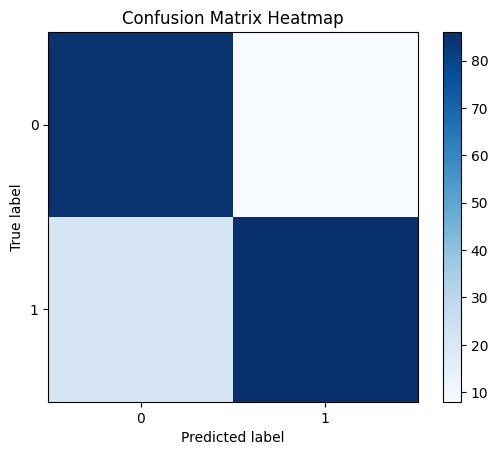

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             recall_score, precision_score, f1_score, accuracy_score,
                             PrecisionRecallDisplay, average_precision_score, precision_recall_curve,
                             RocCurveDisplay, roc_auc_score, roc_curve,
                             mean_squared_error, root_mean_squared_error, r2_score)

__version__ = 1.0


def plot_precision_recall_curve(y_proba, pred_proba, estimator_name=None, title=None):
    """Precision Recall Curve 시각화 함수
    Args:
        y_proba: ndarray - 정답
        pred_proba: 모델이 추정한 양성(Positive-1)일 확률
        estimator_name: str - 모델 이름. 시각화시 범례에 출력할 모델이름
        title: str - plot 제목
    Returns:
    Raises:"""
    # ap score 계산
    ap_score = average_precision_score(y_proba, pred_proba)
    # thresh 변화에 따른 precision, recall 값들 계산.
    precision, recall, _ = precision_recall_curve(y_proba, pred_proba)
    # 시각화
    disp = PrecisionRecallDisplay(
        precision, recall, 
        average_precision=ap_score,  
        estimator_name=estimator_name
    )
    disp.plot()
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_proba, pred_proba, estimator_name=None, title=None):
    """ROC Curve 시각화
    Args:
        y_proba: ndarray - 정답
        pred_proba: 모델이 추정한 양성(Positive-1)일 확률
        estimator_name: str - 모델 이름. 시각화시 범례에 출력할 모델이름
        title: str - plot 제목
    Returns:
    Raises:"""
    ## ROC-AUC score 계산
    auc_score = roc_auc_score(y_proba, pred_proba)
    ## Thresh 변화에 따른 TPR(Recall) 과 FPR(위양성율) 계산
    fpr, tpr, _ = roc_curve(y_proba, pred_proba)
    ### 시각화
    disp = RocCurveDisplay(
        fpr=fpr, tpr=tpr, 
        estimator_name=estimator_name,
        roc_auc=auc_score
    )
    disp.plot()
    if title:
        plt.title(title)
    plt.show()

def plot_confusion_matrix(y, pred, title=None):
    """Confusion matrix 시각화 함수
    Args:
        y: ndarray - 정답
        pred: ndarray - 모델 추정결과
        title: str - 출력할 제목. default=None
    Returns:
    Raises::
    """
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    if title:
        plt.title(title)
    plt.show()

# heatmap 시각화


if __name__ == "__main__":
    # test
    import numpy as np
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression

    X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    plot_precision_recall_curve(y_test, y_proba)
    plot_roc_curve(y_test, y_proba)
    plot_confusion_matrix(y_test, y_pred)
    

